_This notebook contains code and comments from Section 4.5 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 4.5	LogitBoost: Boosting with the Logistic Loss

We introduce a second boosting algorithm called [LogitBoost](https://en.wikipedia.org/wiki/LogitBoost). The development of LogitBoost was motivated by the desire to bring loss functions from established classification models such as logistic regression into the AdaBoost framework. In this manner, the general boosting framework can be applied to specific classification settings in order to train boosted ensembles with properties similar to those classifiers.

Under the hood, AdaBoost optimizes the **exponential loss**. LogitBoost, on the other hand, optimizes the **logistic loss**, which logistic regression also uses. The figure below compares the two loss functions.

In [3]:
import matplotlib.pyplot as plt
from visualization import get_colors
import numpy as np

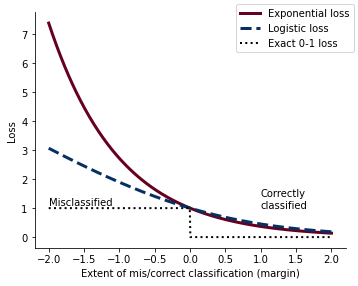

In [5]:
%matplotlib inline

cm = get_colors(colormap='RdBu', n_colors=2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

x = np.linspace(-2.0, 2.0, num=500)
ax.plot(x, np.exp(-x), linewidth=3, c=cm[0], marker=None)
ax.plot(x, np.log(1 + np.exp(-x)) / np.log(2), linewidth=3, linestyle='--', c=cm[1], marker=None)
ax.plot(x, (-x >= 0).astype(float), linewidth=2, linestyle=':', c='k', marker=None)
ax.text(-2, 1.1, 'Misclassified')
ax.text(1, 1, 'Correctly\nclassified')
ax.set_xlabel('Extent of mis/correct classification (margin)')
ax.set_ylabel('Loss')
fig.legend(['Exponential loss', 'Logistic loss', 'Exact 0-1 loss'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
pngFile = './figures/CH04_F16_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

The LogitBoost algorithm performs the following steps within each iteration. The probability $P(y_i=1 | x_i)$ is abbreviated $P_i$:
1. Compute the working response, or how much the prediction probability differs from the true label, 
\\[ z_i = \frac{y_i-P_i}{P_i (1-P_i)} \\]

2. Update the example weights, $D_i=P_i (1-P_i)$
3. Train a weak **regression stump** $h_t (x)$ on the weighted examples $(x_i,z_i,D_i)$
4. Update the ensemble, $F_{t+1}(x) = F_t(x) + h_t(x)$
5. Update the example probabilities
\\[ P_i = \frac{1}{1+e^{-F_{t+1}(x) }}. \\]


**Listing 4.5**: LogitBoost for classification

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from scipy.special import expit

def fit_logitboosting(X, y, n_estimators=10):
    n_samples, n_features = X.shape
    D = np.ones((n_samples, )) / n_samples            
    p = np.full((n_samples, ), 0.5)                   
    estimators = []                                   

    for t in range(n_estimators):
        z = (y - p) / (p * (1 - p))
        D = p * (1 - p)

        h = DecisionTreeRegressor(max_depth=1)
        h.fit(X, z, sample_weight=D)                
        estimators.append(h)


        if t == 0:
            margin = np.array([h.predict(X) 
                       for h in estimators]).reshape(-1, )
        else:
            margin = np.sum(np.array([h.predict(X) 
                       for h in estimators]), axis=0)

        p = expit(margin)

    return estimators

The predict_boosting function described in Listing 4.2 can be used to make predictions with the LogitBoost ensembles as well. However, LogitBoost requires training labels to be in 0/1 form while AdaBoost requires them to be in -1/1 form. Thus, we modify that function slightly to return 0/1 labels.

**Listing 4.5**: LogitBoost for prediction

In [32]:
def predict_logit_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for h in estimators:
        pred += h.predict(X)

    y = (np.sign(pred) + 1) / 2

    return y

As with AdaBoost, we can visualize how the ensemble trained by LogitBoost evolves over several iterations.

In [33]:
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
X, y = make_moons(n_samples=200, noise=0.125)

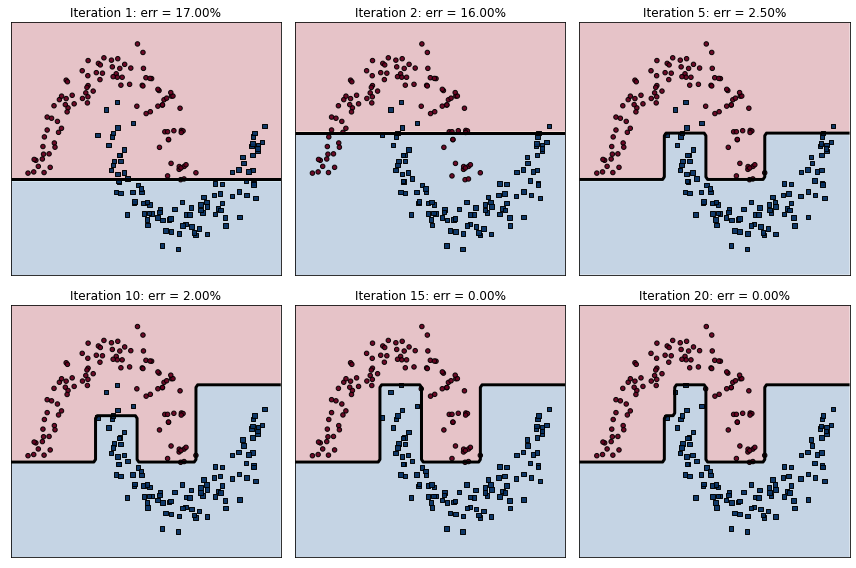

In [38]:
%matplotlib inline

from visualization import plot_2d_classifier

n_samples, n_features = X.shape
n_estimators = 20
p = np.full((n_samples,), 0.5)         # Initialize the prediction probabilities
estimators = []                        # Initialize an empty ensemble

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax_index = -1

for t in range(n_estimators):
    z = (y - p) / (p * (1 - p))
    D = p * (1 - p)

    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, z, sample_weight=D)  # Train a weak learner using sample weights
    estimators.append(h)

    if t == 0:
        margin = np.array([h.predict(X) for h in estimators]).reshape(-1, )
    else:
        margin = np.sum(np.array([h.predict(X) for h in estimators]), axis=0)
    p = expit(margin)

    # -- Plot the ensemble
    if t in [0, 1, 4, 9, 14, 19]:
        ax_index += 1
        r, c = np.divmod(ax_index, 3)

        ypred = predict_logit_boosting(X, estimators)
        err = (1 - accuracy_score(y, ypred)) * 100


        title = 'Iteration {0}: err = {1:4.2f}%'.format(t + 1, err)
        plot_2d_classifier(ax[r, c], X, y, 
                           predict_function=predict_logit_boosting, predict_args=estimators,
                           alpha=0.25, xlabel=None, ylabel=None, 
                           title=title, colormap='RdBu')
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        
        
fig.tight_layout()        
pngFile = './figures/CH04_F17_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)